### 线性神经网络的从零实现
例子：用线性回归模型拟合带有服从-0.5 到 0.5 的均匀分布噪声的正弦函数

In [230]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import random

生成数据集: 正弦函数+随机噪声

In [231]:
num_observations = 100
x = np.linspace(-3, 3, num_observations)
y = np.sin(x) + np.random.uniform(-0.5, 0.5, num_observations)

画出训练数据散点图

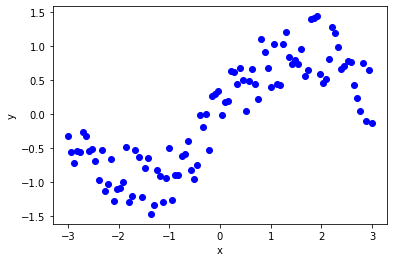

In [232]:
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y, "ob")
plt.show()

实现一个小批量读取数据集的迭代器  
每 10 个数据随机取 1 个

In [233]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [234]:
batch_size = 10
features = torch.from_numpy(x).type(torch.float32).reshape(-1, 1)
labels = torch.from_numpy(y).type(torch.float32).reshape(-1, 1)

for _X, _y in data_iter(batch_size, features, labels):
    print(_X, '\n', _y)
    break

tensor([[-2.2727],
        [ 1.9091],
        [ 0.0909],
        [ 2.5758],
        [-2.0303],
        [-1.0000],
        [ 2.3939],
        [ 1.1818],
        [ 0.1515],
        [-2.6364]]) 
 tensor([[-1.1310],
        [ 1.4419],
        [ 0.1782],
        [ 0.7734],
        [-1.1041],
        [-0.4980],
        [ 0.6712],
        [ 0.4336],
        [ 0.2011],
        [-0.3118]])


初始化模型参数

In [235]:
w = torch.ones((1,1), requires_grad=True, dtype=torch.float32)
b = torch.zeros(1, requires_grad=True, dtype=torch.float32)
w, b

(tensor([[1.]], requires_grad=True), tensor([0.], requires_grad=True))

定义模型

In [236]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [237]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化函数 SGD

In [238]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

开始训练

In [239]:
lr = 0.0001
num_epochs = 100
net = linreg
loss = squared_loss

In [240]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(_X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(X, w, b), y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}, w {w[0, 0]}, b {b[0]}')

epoch 1, loss 1.053528, w 0.9966095089912415, b -5.746930037275888e-05
epoch 2, loss 0.865971, w 0.9933732748031616, b -0.00011485163850011304
epoch 3, loss 0.299636, w 0.9897872805595398, b -0.00017201804439537227
epoch 4, loss 0.608841, w 0.9863275289535522, b -0.00022896076552569866
epoch 5, loss 0.794063, w 0.9828867316246033, b -0.0002857569488696754
epoch 6, loss 1.156037, w 0.9795156121253967, b -0.0003423540620133281
epoch 7, loss 1.893879, w 0.9760686755180359, b -0.0003987944801338017
epoch 8, loss 1.071298, w 0.9726402759552002, b -0.00045500913984142244
epoch 9, loss 0.284232, w 0.9692593216896057, b -0.0005110726342536509
epoch 10, loss 0.770757, w 0.9660803079605103, b -0.0005669227102771401
epoch 11, loss 0.434272, w 0.962758481502533, b -0.0006226333789527416
epoch 12, loss 0.659434, w 0.9591755867004395, b -0.0006781755946576595
epoch 13, loss 0.916419, w 0.9559375047683716, b -0.0007335745031014085
epoch 14, loss 0.929990, w 0.9525140523910522, b -0.000788764096796512

展示训练结果

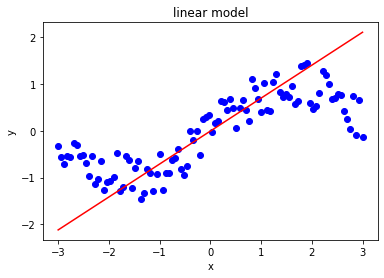

In [241]:
_y = net(features, w, b)
plt.title("linear model")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(features.numpy(), labels.numpy(), 'ob')
plt.plot(features.numpy(), _y.detach().numpy(), 'r')
plt.show()

### 坑
- 注意对原始数据进行处理时,最后需要的维度是怎么样的,维度不对矩阵乘法运行不了
- 留意 tensor 中元素的数据类型
- 千万记得在自动求导后清除梯度(param.grad.zero_())